### Mkhanyisi Gamedze
#### COSI 165B Deep Learning
#### Term Project Analysis - Google Cloud
#### 10 May 2022



DataSet link: https://competitions.codalab.org/competitions/4081#participate-get-data or https://chalearnlap.cvc.uab.cat/dataset/17/description/

In [11]:
import os
import pandas as pd
import numpy as np
from PIL import Image
from matplotlib import pyplot as plt
from scipy import ndimage, misc
import imageio
import cv2

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import torchvision.models as models

from tqdm import tqdm

### Load Data

Build labels Dataframe

<b>Train Labels</b>

In [12]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [13]:
r="/content/drive/MyDrive/COSI 165B data"
os.chdir(r)
print(os.getcwd())

/content/drive/MyDrive/COSI 165B data


### Load saved data

In [14]:
os.chdir(r)
print(os.getcwd())
os.listdir()

/content/drive/MyDrive/COSI 165B data


['reencoded_smallerdataY.npy', 'smallerdataX.npy']

In [15]:
#os.chdir('./Numpy Clean Dataset')

In [16]:
fulldataX=np.load('smallerdataX.npy')

fulldataX.shape

(2254, 256, 256, 3)

In [17]:
fulldataY=np.load('reencoded_smallerdataY.npy')
fulldataY.shape

(2254, 1)

<b>Test Transform</b>

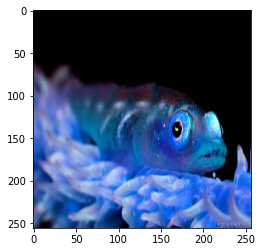

In [18]:
plt.imshow(fulldataX[1])
plt.show()

In [19]:
fulldataY.shape

(2254, 1)

#### To Tensor

In [20]:
tensordataX = torch.FloatTensor(fulldataX)

tensordataY = torch.FloatTensor(fulldataY.astype(int))


tensordataX.shape, tensordataY.shape

(torch.Size([2254, 256, 256, 3]), torch.Size([2254, 1]))

<b>Permute Images so input channel is color for convolution</b>

In [21]:
tensordataX=tensordataX.permute(0,3,1,2)
tensordataX.shape

torch.Size([2254, 3, 256, 256])

### Train-Test split (80 : 20)

In [22]:
p=int(0.8*(tensordataX.shape[0]))

trainX=tensordataX[:p]
testX=tensordataX[p:]
trainY=tensordataY[:p]
testY=tensordataY[p:]

trainX.shape, trainY.shape, testX.shape, testY.shape

(torch.Size([1803, 3, 256, 256]),
 torch.Size([1803, 1]),
 torch.Size([451, 3, 256, 256]),
 torch.Size([451, 1]))

### Vanilla CNN model

In [23]:
# CNN model
class Net(nn.Module):

    def __init__(self):
        super().__init__()
        
        # define convolution layers
        """
        self.conv1 = nn.Conv2d(3, 96, kernel_size=(7,7), stride=2)
        self.conv2 = nn.Conv2d(96, 512, kernel_size=(3,3), stride=1)
        """
        self.conv1 = nn.Conv2d(3, 6, kernel_size=(5,5), stride=1)
        self.conv2 = nn.Conv2d(6, 16, kernel_size=(5,5), stride=1)
        
        
        # figure out output conv flat length
        x = torch.randn(1,3,256,256)
        self._to_linear = None
        self.convs(x)
        
        # fully connected layers
        self.fc1 = nn.Linear(self._to_linear, 500)
        self.fc2 = nn.Linear(500,250)
        self.fc3 = nn.Linear(250, 11)
        self.softmax = nn.Softmax(dim=1)

        
    def convs(self, x):
        # max pooling over 2x2 both Conv layers
        x=self.conv1(x)
        x=F.relu(x)
        x =F.max_pool2d(x, (2, 2))
        
        x = F.max_pool2d(F.relu(self.conv2(x)), (2, 2))
        
        
        #print(x.shape)
        # first pass, figure flat length
        if self._to_linear is None:
            print("x[0] : ",x[0].shape)
            self._to_linear = x[0].shape[0]*x[0].shape[1]*x[0].shape[2]
        return x
    
    def forward(self, x):
        x = self.convs(x) # first two convolutional layers
        x = x.reshape(-1, self._to_linear) # flatten x
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        #x = F.sigmoid(self.fc3(x)) # Sigmoidal activation for output layer since two class problem
        x=F.log_softmax(self.fc3(x), dim=1)
        
        #x=self.softmax(self.fc3(x))
        #print("x:",x.shape)
        #print("x:",x)
        return x

In [24]:
vanillaCNN=Net()

x[0] :  torch.Size([16, 61, 61])


In [25]:
dev = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device "%s" for training' % dev)

Using device "cuda" for training


In [26]:
vanillaCNN.to(dev)

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=59536, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=250, bias=True)
  (fc3): Linear(in_features=250, out_features=11, bias=True)
  (softmax): Softmax(dim=1)
)

In [27]:
#transform = torchvision.transforms.ToTensor()
img=trainX[:19].cuda()
print("image shape: ",img.shape)
print("reshaped img: ",img.view(-1,3,256,256).shape)

v=torch.randn(1,3,256,256).cuda()
print("v shape: ",v.shape)
r=vanillaCNN.forward(v)
simg=torch.squeeze(img.view(-1,3,256,256))
print("squezzed img: ",simg.shape)


im= torch.rand(10, 3, 256,256).cuda()
print("rand tensor shape: ",im.shape)
c=vanillaCNN.forward(im)

print("output: ",r)
print("rand img output: ",c.shape)

image shape:  torch.Size([19, 3, 256, 256])
reshaped img:  torch.Size([19, 3, 256, 256])
v shape:  torch.Size([1, 3, 256, 256])
squezzed img:  torch.Size([19, 3, 256, 256])
rand tensor shape:  torch.Size([10, 3, 256, 256])
output:  tensor([[-2.3425, -2.3265, -2.4320, -2.3626, -2.4112, -2.4393, -2.4382, -2.3140,
         -2.4259, -2.4598, -2.4386]], device='cuda:0',
       grad_fn=<LogSoftmaxBackward0>)
rand img output:  torch.Size([10, 11])


In [28]:
b=vanillaCNN.forward(img)
print("batch result: ",b.shape)

batch result:  torch.Size([19, 11])


In [29]:
print("CNN Model:\n",vanillaCNN)

CNN Model:
 Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=59536, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=250, bias=True)
  (fc3): Linear(in_features=250, out_features=11, bias=True)
  (softmax): Softmax(dim=1)
)


#### Train model

In [30]:
EPOCHS = 40
BATCH_SIZE = 100

In [31]:
min_loss = np.Inf #lowest loss will be the loaded model

loss_function = nn.CrossEntropyLoss().to(dev) 

optimizer = optim.Adam(vanillaCNN.parameters(),lr=0.00001)

epoch_num=[]
loss_arr=[]

enum=0
for epoch in range(EPOCHS):
    train_loss = 0
    vanillaCNN.train()
    for i in tqdm(range(0, len(trainX), BATCH_SIZE)): 
        #print(f"{i}:{i+BATCH_SIZE}")
        
        batch_X = trainX[i:i+BATCH_SIZE].to(dev)
        batch_y = trainY[i:i+BATCH_SIZE].to(dev)
        batch_y=batch_y.view(len(batch_y)).type(torch.LongTensor)
        
        vanillaCNN.zero_grad()
        #print("batch shape: ",batch_X.shape)
        batch_X=batch_X.cuda()
        batch_y=batch_y.cuda()

        outputs = vanillaCNN(batch_X)
        outputs.to(dev)
        #print("result shape: ",outputs.shape,batch_y.shape)
        
        #print(outputs.dtype)
        #print(batch_y.dtype)
        #print(outputs.shape," <=> ",batch_y.shape)
        
        loss = loss_function(outputs, batch_y)
        loss.backward()
        optimizer.step()    #update weights
        
        #print(loss.item())
        #print(loss.item()," - ",len(train_x))
        train_loss += loss.item()/len(trainX)
    #print("train loss: ",train_loss)
    if epoch % 5 == 0:
        print('Epoch: {}, Train Loss: {:.4f}, Current Min Loss: {:.4f}\n'.format(   #print training loss at each step
            epoch,
            train_loss,
            min_loss
        )) 
    if train_loss < min_loss:   
        min_loss = train_loss
    print(train_loss)
    epoch_num.append(enum)
    loss_arr.append(train_loss)
    enum+=1

100%|██████████| 19/19 [00:02<00:00,  8.93it/s]


Epoch: 0, Train Loss: 0.0808, Current Min Loss: inf

0.0807884853207756


100%|██████████| 19/19 [00:01<00:00,  9.54it/s]


0.05540062610268659


100%|██████████| 19/19 [00:01<00:00,  9.52it/s]


0.03778126401102549


100%|██████████| 19/19 [00:02<00:00,  9.49it/s]


0.03293203547208493


100%|██████████| 19/19 [00:01<00:00,  9.53it/s]


0.02762694770074592


100%|██████████| 19/19 [00:02<00:00,  9.49it/s]


Epoch: 5, Train Loss: 0.0274, Current Min Loss: 0.0276

0.0274355157970126


100%|██████████| 19/19 [00:02<00:00,  9.50it/s]


0.025983725811333642


100%|██████████| 19/19 [00:01<00:00,  9.51it/s]


0.024450765431952088


100%|██████████| 19/19 [00:02<00:00,  9.44it/s]


0.023292258497548648


100%|██████████| 19/19 [00:02<00:00,  9.44it/s]


0.022828897906553063


100%|██████████| 19/19 [00:02<00:00,  9.13it/s]


Epoch: 10, Train Loss: 0.0229, Current Min Loss: 0.0228

0.02294407956017036


100%|██████████| 19/19 [00:02<00:00,  8.05it/s]


0.021977973076051562


100%|██████████| 19/19 [00:02<00:00,  8.40it/s]


0.021579460057528633


100%|██████████| 19/19 [00:02<00:00,  9.42it/s]


0.020453869391499263


100%|██████████| 19/19 [00:02<00:00,  9.43it/s]


0.019661627172663416


100%|██████████| 19/19 [00:02<00:00,  9.42it/s]


Epoch: 15, Train Loss: 0.0193, Current Min Loss: 0.0197

0.019301635788105887


100%|██████████| 19/19 [00:02<00:00,  9.45it/s]


0.018697290753101677


100%|██████████| 19/19 [00:02<00:00,  9.46it/s]


0.018056976614613966


100%|██████████| 19/19 [00:02<00:00,  9.42it/s]


0.0178355240054879


100%|██████████| 19/19 [00:02<00:00,  9.45it/s]


0.017221717574053583


100%|██████████| 19/19 [00:02<00:00,  9.47it/s]


Epoch: 20, Train Loss: 0.0169, Current Min Loss: 0.0172

0.016911979078734114


100%|██████████| 19/19 [00:02<00:00,  9.42it/s]


0.016238271859508057


100%|██████████| 19/19 [00:02<00:00,  9.37it/s]


0.015946001301019048


100%|██████████| 19/19 [00:02<00:00,  9.40it/s]


0.015548982038160061


100%|██████████| 19/19 [00:02<00:00,  9.36it/s]


0.015119118605654106


100%|██████████| 19/19 [00:02<00:00,  9.38it/s]


Epoch: 25, Train Loss: 0.0145, Current Min Loss: 0.0151

0.014456809274707643


100%|██████████| 19/19 [00:02<00:00,  9.36it/s]


0.014317952249358248


100%|██████████| 19/19 [00:02<00:00,  9.40it/s]


0.013505967152090586


100%|██████████| 19/19 [00:02<00:00,  7.89it/s]


0.01349009768505329


100%|██████████| 19/19 [00:02<00:00,  8.77it/s]


0.012754611767047454


100%|██████████| 19/19 [00:02<00:00,  9.40it/s]


Epoch: 30, Train Loss: 0.0127, Current Min Loss: 0.0128

0.012728525858725762


100%|██████████| 19/19 [00:02<00:00,  9.39it/s]


0.012351124801043334


100%|██████████| 19/19 [00:02<00:00,  9.35it/s]


0.011987843271293246


100%|██████████| 19/19 [00:02<00:00,  9.33it/s]


0.011441432041360384


100%|██████████| 19/19 [00:02<00:00,  9.40it/s]


0.01114846137055277


100%|██████████| 19/19 [00:02<00:00,  9.39it/s]


Epoch: 35, Train Loss: 0.0107, Current Min Loss: 0.0111

0.010665852720609026


100%|██████████| 19/19 [00:02<00:00,  9.33it/s]


0.01047131899409554


100%|██████████| 19/19 [00:02<00:00,  9.32it/s]


0.01027485220866093


100%|██████████| 19/19 [00:02<00:00,  9.35it/s]


0.009967518419221548


100%|██████████| 19/19 [00:02<00:00,  9.35it/s]

0.009360191955670706


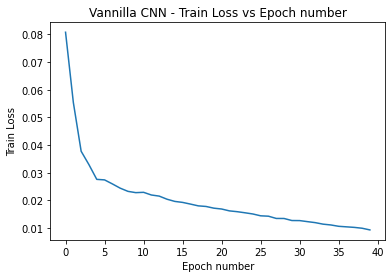

In [32]:
plt.plot(epoch_num, loss_arr)
plt.title('Vannilla CNN - Train Loss vs Epoch number')
plt.xlabel('Epoch number')
plt.ylabel('Train Loss')
plt.show()

#### Test

In [39]:
#def test(model,test_x,test_y):
def model_test(test_x,test_y, model, epoch_num=EPOCHS):
    model.train(False)
    correct = 0
    total = 0

    #print(test_y)
    with torch.no_grad():
        for i in tqdm(range(len(test_x))):
            real_class = test_y[i].to(dev)
            images=test_x[i].view(-1,3,256,256).to(dev)
            net_out = model(images) # returns a list, 

            predicted_class = torch.argmax(net_out,dim=1)
            #print(net_out," =>",predicted_class," : ",real_class)
            if predicted_class == real_class:
                correct += 1
                #print(net_out," =>",predicted_class," : ",real_class)
            total += 1
    print("Accuracy: ", round((correct/total)*100, 3)," % ")

In [40]:
vanillaCNN.train(False)
correct = 0
total = 0

#print(test_y)

with torch.no_grad():
    for i in tqdm(range(len(testX))):
        real_class = testY[i].to(dev)
        images=testX[i].view(-1,3,256,256).to(dev)
        net_out = vanillaCNN(images) # returns a list, 
        
        predicted_class = torch.argmax(net_out,dim=1)
        #print(net_out," =>",predicted_class," : ",real_class)
        #print(predicted_class.shape," : ",real_class.shape)
        if predicted_class == real_class:
            correct += 1
            #print(net_out," =>",predicted_class," : ",real_class)
        total += 1
print("Initial Model Accuracy: ", round((correct/total)*100, 3)," % ")

100%|██████████| 451/451 [00:00<00:00, 697.57it/s]

Initial Model Accuracy:  34.59  % 


### Model Train function

In [41]:
def model_train(model,trainX,trainY,testX,testY):
    trainX.to(dev)
    testX.to(dev)
    trainY.to(dev)
    testY.to(dev)
    model.to(dev)

    min_loss = np.Inf
    epoch_num=[]
    loss_arr=[]

    enum=0
    for epoch in range(EPOCHS):
        train_loss = 0
        model.train()

        for i in tqdm(range(0, len(trainX), BATCH_SIZE)): 
            #print(f"{i}:{i+BATCH_SIZE}")

            batch_X = trainX[i:i+BATCH_SIZE].to(dev)
            batch_y = trainY[i:i+BATCH_SIZE].to(dev)
            batch_y=batch_y.view(len(batch_y)).type(torch.LongTensor)

            # Clear accumulated gradients from previous iteration
            # before backpropagating. 
            model.zero_grad()
            batch_X=batch_X.cuda()
            batch_y=batch_y.cuda()
            #print(batch_X.shape)
            outputs = model(batch_X)
            outputs.to(dev)

            #print("result shape: ",outputs.shape,batch_y.shape)

            #print(outputs.dtype)
            #print(batch_y.dtype)

            loss = loss_function(outputs, batch_y)
            loss.backward()
            optimizer.step()    #update weights

            #print(loss.item())
            #print(loss.item()," - ",len(train_x))
            train_loss += loss.item()/len(trainX)
        #print("train loss: ",train_loss)
        if epoch % 5 == 0:
            print('Epoch: {}, Train Loss: {:.4f}, Current Min Loss: {:.4f}\n'.format(   #print training loss at each step
                epoch,
                train_loss,
                min_loss
            )) 
        if train_loss < min_loss:   
            min_loss = train_loss
        epoch_num.append(enum)
        loss_arr.append(train_loss)
        enum+=1
    
    model_test(testX,testY, model, EPOCHS)

    return model,epoch_num,loss_arr

In [42]:
EPOCHS = 50
BATCH_SIZE = 100

In [43]:
trained_vanillaCNN, epoch_num,loss_arr = model_train(vanillaCNN, trainX,trainY,testX,testY)

100%|██████████| 19/19 [00:02<00:00,  8.99it/s]


Epoch: 0, Train Loss: 0.0031, Current Min Loss: inf



100%|██████████| 19/19 [00:02<00:00,  8.53it/s]


Epoch: 5, Train Loss: 0.0020, Current Min Loss: 0.0023



100%|██████████| 19/19 [00:02<00:00,  9.34it/s]


Epoch: 10, Train Loss: 0.0016, Current Min Loss: 0.0017



100%|██████████| 19/19 [00:02<00:00,  9.23it/s]


Epoch: 15, Train Loss: 0.0013, Current Min Loss: 0.0013



100%|██████████| 19/19 [00:02<00:00,  9.27it/s]


Epoch: 20, Train Loss: 0.0010, Current Min Loss: 0.0011



100%|██████████| 19/19 [00:02<00:00,  9.17it/s]


Epoch: 25, Train Loss: 0.0009, Current Min Loss: 0.0009



100%|██████████| 19/19 [00:02<00:00,  9.23it/s]


Epoch: 30, Train Loss: 0.0007, Current Min Loss: 0.0007



100%|██████████| 19/19 [00:02<00:00,  9.22it/s]


Epoch: 35, Train Loss: 0.0006, Current Min Loss: 0.0006



100%|██████████| 19/19 [00:02<00:00,  9.23it/s]


Epoch: 40, Train Loss: 0.0005, Current Min Loss: 0.0005



100%|██████████| 19/19 [00:02<00:00,  9.19it/s]


Epoch: 45, Train Loss: 0.0004, Current Min Loss: 0.0004



100%|██████████| 451/451 [00:00<00:00, 716.44it/s]

Accuracy:  37.251  % 


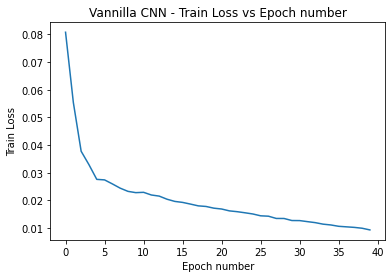

In [70]:
plt.plot(epoch_num, loss_arr)
plt.title('Vannilla CNN - Train Loss vs Epoch number')
plt.xlabel('Epoch number')
plt.ylabel('Train Loss')
plt.show()

### ResNet18

In [50]:
resNet = models.resnet18(pretrained=True)

num_ftrs = resNet.fc.in_features
print(num_ftrs)

512


In [51]:
import gc
gc.collect()

283

In [52]:
resNet.fc = nn.Linear(num_ftrs, 11)
resNet.to(dev)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [53]:


optimizer = optim.Adam(resNet.parameters(),lr=0.00001)
criterion = nn.CrossEntropyLoss().to(dev) 

In [54]:
trained_resNet, epoch_num,loss_arr = model_train(resNet, trainX,trainY,testX,testY)

100%|██████████| 19/19 [00:10<00:00,  1.76it/s]


Epoch: 0, Train Loss: 0.0266, Current Min Loss: inf



100%|██████████| 19/19 [00:10<00:00,  1.75it/s]


Epoch: 5, Train Loss: 0.0229, Current Min Loss: 0.0235



100%|██████████| 19/19 [00:10<00:00,  1.74it/s]


Epoch: 10, Train Loss: 0.0206, Current Min Loss: 0.0210



100%|██████████| 19/19 [00:10<00:00,  1.73it/s]


Epoch: 15, Train Loss: 0.0186, Current Min Loss: 0.0190



100%|██████████| 19/19 [00:10<00:00,  1.73it/s]


Epoch: 20, Train Loss: 0.0170, Current Min Loss: 0.0173



100%|██████████| 19/19 [00:10<00:00,  1.73it/s]


Epoch: 25, Train Loss: 0.0155, Current Min Loss: 0.0157



100%|██████████| 19/19 [00:11<00:00,  1.73it/s]


Epoch: 30, Train Loss: 0.0142, Current Min Loss: 0.0144



100%|██████████| 19/19 [00:10<00:00,  1.73it/s]


Epoch: 35, Train Loss: 0.0130, Current Min Loss: 0.0132



100%|██████████| 19/19 [00:10<00:00,  1.73it/s]


Epoch: 40, Train Loss: 0.0119, Current Min Loss: 0.0121



100%|██████████| 19/19 [00:10<00:00,  1.73it/s]


Epoch: 45, Train Loss: 0.0109, Current Min Loss: 0.0111



100%|██████████| 451/451 [00:01<00:00, 233.89it/s]

Accuracy:  47.228  % 


In [ ]:
plt.plot(epoch_num, loss_arr)
plt.title('ResNet18 - Train Loss vs Epoch number')
plt.xlabel('Epoch number')
plt.ylabel('Train Loss')
plt.show()

### AlexNet

In [56]:
class AlexNet(nn.Module):
    def __init__(self, num_classes=11):
        super(AlexNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(64, 192, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(192, 384, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),
        )
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 12 * 12, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        #print("conv output shape: ",x.shape)
        x = x.reshape(x.size(0), 256 * 12 * 12)
        x = F.log_softmax(self.classifier(x),dim=1)
        return x

In [57]:
alexNet=AlexNet(11)

In [58]:
alexNet.to(dev)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=36864, out_features=4096, bias=True)
    (2): ReLU(inplace=True)
    (3): Dropout(p=0.5, inplace=False)
    (4): Linear(in_features=4096, out_features=4096, bias=True)
  

In [60]:
optimizer = optim.Adam(alexNet.parameters(),lr=0.00001)

In [59]:
print(img.shape)
b=alexNet(img)
print("batch result: ",b.shape)
b

torch.Size([19, 3, 256, 256])
batch result:  torch.Size([19, 11])


tensor([[-2.3375, -2.1408, -2.6038, -1.8938, -2.8720, -2.0961, -3.0014, -2.8152,
         -2.7308, -2.1522, -2.3985],
        [-2.6709, -1.9226, -2.4690, -2.2298, -2.6213, -2.3915, -2.6389, -2.7923,
         -2.2887, -2.4054, -2.2650],
        [-3.0174, -1.6858, -2.7930, -1.6392, -3.0758, -2.0017, -2.4238, -2.7318,
         -3.0710, -2.8211, -2.6657],
        [-2.9445, -2.0643, -2.6830, -1.6262, -2.8924, -1.7033, -2.7314, -2.9446,
         -2.6149, -2.9449, -2.5988],
        [-2.6930, -1.8640, -2.7632, -2.3510, -2.8262, -2.2975, -2.3576, -2.3095,
         -2.2374, -2.9081, -2.2644],
        [-2.7302, -2.4507, -2.2059, -2.4719, -2.5122, -1.9316, -2.5760, -2.5980,
         -2.2323, -2.5666, -2.3709],
        [-2.6537, -1.7955, -2.6045, -2.1934, -3.0186, -1.9020, -3.1040, -2.3998,
         -2.2544, -2.8141, -2.5326],
        [-2.3084, -2.1010, -2.5853, -2.4989, -2.7828, -1.6915, -3.3167, -2.6202,
         -2.4296, -2.4581, -2.3875],
        [-2.8014, -1.8306, -2.4322, -2.5602, -3.0229, -2

In [61]:
trained_alexNet , epoch_num,loss_arr= model_train(alexNet, trainX,trainY,testX,testY)

100%|██████████| 19/19 [00:09<00:00,  2.05it/s]


Epoch: 0, Train Loss: 0.0473, Current Min Loss: inf



100%|██████████| 19/19 [00:09<00:00,  2.03it/s]


Epoch: 5, Train Loss: 0.0241, Current Min Loss: 0.0246



100%|██████████| 19/19 [00:09<00:00,  2.00it/s]


Epoch: 10, Train Loss: 0.0221, Current Min Loss: 0.0225



100%|██████████| 19/19 [00:09<00:00,  1.98it/s]


Epoch: 15, Train Loss: 0.0205, Current Min Loss: 0.0216



100%|██████████| 19/19 [00:09<00:00,  1.98it/s]


Epoch: 20, Train Loss: 0.0188, Current Min Loss: 0.0190



100%|██████████| 19/19 [00:09<00:00,  1.98it/s]


Epoch: 25, Train Loss: 0.0179, Current Min Loss: 0.0174



100%|██████████| 19/19 [00:09<00:00,  1.98it/s]


Epoch: 30, Train Loss: 0.0154, Current Min Loss: 0.0155



100%|██████████| 19/19 [00:09<00:00,  1.97it/s]


Epoch: 35, Train Loss: 0.0137, Current Min Loss: 0.0135



100%|██████████| 19/19 [00:09<00:00,  1.96it/s]


Epoch: 40, Train Loss: 0.0115, Current Min Loss: 0.0115



100%|██████████| 19/19 [00:09<00:00,  1.97it/s]


Epoch: 45, Train Loss: 0.0088, Current Min Loss: 0.0088



100%|██████████| 451/451 [00:01<00:00, 232.71it/s]

Accuracy:  49.002  % 


In [ ]:
plt.plot(epoch_num, loss_arr)
plt.title('AlexNet - Train Loss vs Epoch number')
plt.xlabel('Epoch number')
plt.ylabel('Train Loss')
plt.show()

### Pretrained on ImageNet AlexNet

In [79]:
pretrained_AlexNet = torch.hub.load('pytorch/vision:v0.10.0', 'alexnet', pretrained=True)

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


In [95]:
#pretrained_AlexNet

In [81]:
num_ftrs = pretrained_AlexNet.classifier[6].in_features
num_ftrs

4096

In [82]:
pretrained_AlexNet.classifier[6]= nn.Linear(num_ftrs, 11)
pretrained_AlexNet

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [83]:
optimizer = optim.Adam(pretrained_AlexNet.parameters(),lr=0.00001)

In [84]:
EPOCHS = 40
BATCH_SIZE = 200

In [85]:
retrained_AlexNet, epoch_num,loss_arr = model_train(pretrained_AlexNet, trainX,trainY,testX,testY)

100%|██████████| 10/10 [00:03<00:00,  2.94it/s]


Epoch: 0, Train Loss: 0.1251, Current Min Loss: inf



100%|██████████| 10/10 [00:03<00:00,  2.99it/s]


Epoch: 5, Train Loss: 0.0273, Current Min Loss: 0.0328



100%|██████████| 10/10 [00:03<00:00,  2.96it/s]


Epoch: 10, Train Loss: 0.0159, Current Min Loss: 0.0176



100%|██████████| 10/10 [00:03<00:00,  2.95it/s]


Epoch: 15, Train Loss: 0.0114, Current Min Loss: 0.0122



100%|██████████| 10/10 [00:03<00:00,  2.94it/s]


Epoch: 20, Train Loss: 0.0088, Current Min Loss: 0.0097



100%|██████████| 10/10 [00:03<00:00,  2.93it/s]


Epoch: 25, Train Loss: 0.0077, Current Min Loss: 0.0075



100%|██████████| 10/10 [00:03<00:00,  2.93it/s]


Epoch: 30, Train Loss: 0.0063, Current Min Loss: 0.0064



100%|██████████| 10/10 [00:03<00:00,  2.91it/s]


Epoch: 35, Train Loss: 0.0055, Current Min Loss: 0.0055



100%|██████████| 451/451 [00:00<00:00, 452.07it/s]

Accuracy:  53.437  % 


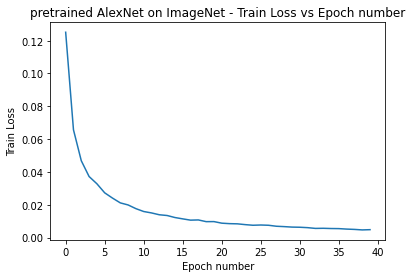

In [86]:
plt.plot(epoch_num, loss_arr)
plt.title('pretrained AlexNet on ImageNet - Train Loss vs Epoch number')
plt.xlabel('Epoch number')
plt.ylabel('Train Loss')
plt.show()

### GoogLeNet

In [88]:
googLeNet=torch.hub.load('pytorch/vision:v0.10.0', 'googlenet', pretrained=True)

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0
Downloading: "https://download.pytorch.org/models/googlenet-1378be20.pth" to /root/.cache/torch/hub/checkpoints/googlenet-1378be20.pth


  0%|          | 0.00/49.7M [00:00<?, ?B/s]

In [94]:
#googLeNet

In [91]:
num_ftrs = googLeNet.fc.in_features
num_ftrs

1024

In [93]:
googLeNet.fc= nn.Linear(num_ftrs, 11)
#googLeNet

In [96]:
optimizer = optim.Adam(googLeNet.parameters(),lr=0.00001)

In [100]:
trained_googLeNet, epoch_num,loss_arr = model_train(googLeNet, trainX,trainY,testX,testY)

RuntimeError: ignored

### Resources

- https://competitions.codalab.org/competitions/4081#participate-get-data
- 


- https://blog.keras.io/running-jupyter-notebooks-on-gpu-on-aws-a-starter-guide.html

##### 